# Solution path 1d fused-lasso

L'algorithme suivant sert à déterminer la fonction 

$$
\lambda >0 \mapsto \hat{\beta}(\lambda)
$$
où $\hat{\beta}(\lambda)$ est solution du problème 
$$
\min_{\beta \in \mathbb{R}^n} \frac{1}{2}\|Y- \beta\|_2^2+\lambda \sum_{i=1}^{n-1}|\beta_{i+1}-\beta_i|
$$
Ou alors de manière équivalente 
$$
\min_{\beta \in \mathbb{R}^n} \frac{1}{2}\|Y- \beta\|_2^2+\lambda \|D\beta\|_1~~ \text{avec}~~ D=\begin{pmatrix}
-1 & 1 & 0 & \cdots & 0 & 0 \\
0 & -1 &1& \cdots & 0 & 0 \\
 &  & & \cdots& &\\
 0&0&0&\cdots&-1&1
\end{pmatrix} \in \mathbb{R}^{(n-1) \times n}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def mat_D1d(n):
    matrix = np.zeros((n-1, n))
    for i in range(n-1):
        matrix[i, i] = -1
        matrix[i, i+1] = 1
    return matrix

In [3]:
### fonction pour ajouter un element à B et le signe à s
def add_and_sort(B, s, i, new_sign):
    B = np.append(B, i)
    s = np.append(s, new_sign)
    B_s_combined = np.array(list(zip(B, s)))
    B_s_sorted = B_s_combined[B_s_combined[:, 0].argsort()]
    B_trie = B_s_sorted[:, 0]
    s_trie = B_s_sorted[:, 1]
    return B_trie, s_trie

def show_dual_path(lam_values, u_values):
    lam_values[0] = 1.2*lam_values[1]
    # Création de la figure et des axes
    fig, ax = plt.subplots()
    u_line = np.linspace(min(lam_values), max(lam_values), 100)
    
    ax.plot(u_line, u_line,linestyle='--', color='k', label='u = lambda')
    ax.plot(u_line, -u_line,linestyle='--', color='k', label='u = -lambda')
    ax.axhline(y=0, color='k', linestyle='--')
    for i in range(u_values.shape[1]):
        ax.plot(lam_values, u_values[:, i], label=f'u{i+1}')
        
    for i in lam_values[1:-1]:
        ax.axvline(x=i, color='k', linestyle=':')
    ax.set_xlabel('lambda')
    ax.set_ylabel('dual coeff')
    ax.set_title('Dual path')
    plt.show()
    
def get_beta(u, y):
    n = np.size(y)
    D = mat_D1d(n)
    beta = np.zeros((u.shape[0], u.shape[1]+1))
    for i in range(u.shape[0]):
        beta[i,:] =y - D.T @ u[i]
    return beta

def show_primal_path(lam, beta):
    lam[0] = 1.2*lam[1]
    fig, ax = plt.subplots()
    for i in lam[1:]:
        ax.axvline(x=i, color='k', linestyle=':')
    for i in range(beta.shape[1]):
        ax.plot(lam, beta[:, i], label=f'u{i+1}')
    ax.set_xlabel('lambda')
    ax.set_ylabel('Primal coeff')
    ax.set_title('Primal path')

In [4]:
def d1_fused_lasso(y):
    start_time = time.time()
    n = np.size(y)
    m = n-1
    D = mat_D1d(n)
    lam = np.inf
    l = np.arange(m)
    B = np.empty(0, dtype=int) ###index qui sont sur la boundary
    s = np.empty(0, dtype=int) ###signe des index sur la boundary
    B_C = np.setdiff1d(l, B).astype(int)  ###index qui ne sont pas sur la boundary
    k = 0
    coeff_a = [] ###matrice contenant les pentes 
    coeff_b = [] ### matrice contenant les ordonnées à l'origine
    u_values = []
    lam_values = []
    lam_values.append(lam)
    for w in range(n):
        DDT_inv = np.linalg.inv(D[B_C,:] @ D[B_C,:].T)  ### [(D_-B)(D_-B).T]^{-1}
        DDT_inv_y = DDT_inv @ D[B_C,:] @ y             
        DDT_inv_s = DDT_inv @ D[B_C,:] @ D[B,:].T @ s
### calcul de u au noeud
        if np.isinf(lam):   ### si lam=inf
            u_B_C = DDT_inv_y
        else:
            u_B_C = DDT_inv_y - lam * DDT_inv_s
        u = np.zeros(m)
        p = 0
        z = 0
        for i in l:
            if i in B_C:
                u[i] = u_B_C[p]
                p += 1
            else:
                u[i] = lam * s[z]
                z += 1
        u_values.append(u)
        ### calcul des pentes et ordonnées 
        a_temp = DDT_inv_s
        b_temp = DDT_inv_y
        a = np.zeros(m)
        b = np.zeros(m)
        z=0
        p=0
        if np.isinf(lam):  ### si lam=inf
            for i in l:
                if i in B_C:
                    a[i] = 0
                    b[i] = b_temp[p]
                    p = p + 1
                else:
                    a[i] = s[z]
                    b[i] = 0   
                    z = z + 1
        else:
            for i in l:
                if i in B_C:
                    a[i] = a_temp[p]
                    b[i] = b_temp[p]
                    p = p + 1
                else:
                    a[i] = s[z]
                    b[i] = 0   
                    z = z + 1
        coeff_a.append(a)
        coeff_b.append(b)
### calcul du prochain "hitting time"
        if w != n-1:
            tip = np.zeros(len(B_C))
            tim = np.zeros(len(B_C))
            if np.isinf(lam):        ### si lam=inf
                val_ti = np.max(abs(u))
                ind_val_ti = np.argmax(abs(u))
                if u[ind_val_ti] < 0:
                    B, s = add_and_sort(B, s, ind_val_ti, -1) 
                else:
                    B, s = add_and_sort(B, s, ind_val_ti, 1)
                lam = val_ti
                lam_values.append(lam)
                B_C = np.setdiff1d(l, B).astype(int)
            else:
                for i in range(len(B_C)):
                    if DDT_inv_s[i] + 1 != 0:
                        tip_val = DDT_inv_y[i] / (DDT_inv_s[i] + 1)
                    else:
                        tip_val = 0
                    if DDT_inv_s[i] - 1 != 0:
                        tim_val = DDT_inv_y[i] / (DDT_inv_s[i] - 1)
                    else:
                        tim_val = 0
                    tip[i] = tip_val
                    tim[i] = tim_val
                tip = [0 if x > lam else x for x in tip] ### toutes les valeur de tip superieures à lambda sont mise à 0
                tim = [0 if x > lam else x for x in tim] ### toutes les valeur de tim superieures à lambda sont mise à 0
                max_tip = np.max(tip)
                argmax_tip = np.argmax(tip)
                max_tim = np.max(tim)
                argmax_tim = np.argmax(tim)
                if max_tim < max_tip:
                    lam = max_tip
                    lam_values.append(lam)
                    i = B_C[argmax_tip]
                    B, s = add_and_sort(B, s, i, 1) 
                    B_C = np.setdiff1d(l, B).astype(int)
                else:
                    lam = max_tim
                    lam_values.append(lam)
                    i = B_C[argmax_tim]
                    B, s = add_and_sort(B, s, i, -1)
                    B_C = np.setdiff1d(l, B).astype(int)
        #print("lam=", lam)
    u_values.append(m*[0])
    lam_values.append(0)
    u_values = np.array(u_values)
    mat_a = np.vstack(coeff_a)
    mat_b = np.vstack(coeff_b)
    end_time = time.time()
    #print("temps d'execution --->",end_time-start_time, "s")
    return lam_values, u_values, mat_a, mat_b
            

In [11]:
#y = np.array([1, 2, 5])
y = np.array([1, -5, 15, -10, 4, 7, -2, -3])
lam, u, mat_a, mat_b = d1_fused_lasso(y)

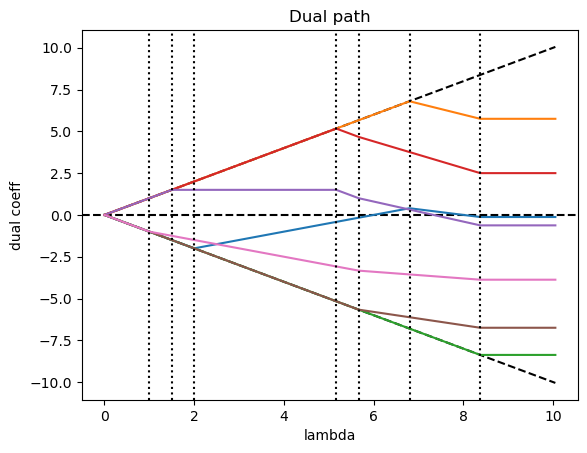

In [12]:
show_dual_path(lam, u)

Or on sait que :
$$
\hat{\beta}(\lambda) = Y-D^\top \hat{u}(\lambda)
$$

[0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875]


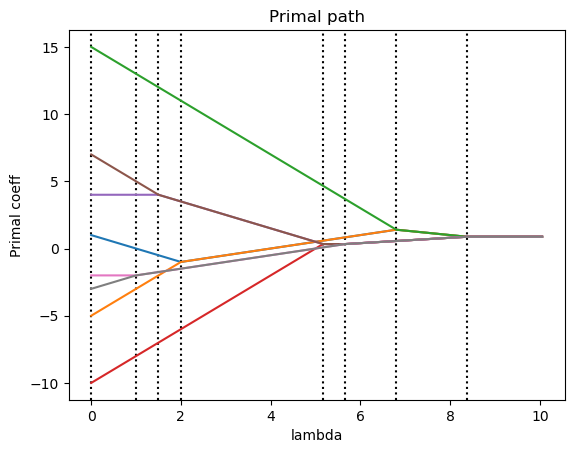

In [13]:
beta = get_beta(u, y)    
show_primal_path(lam, beta)
print(beta[0])

**Essayons d'approximer un signal bruité**

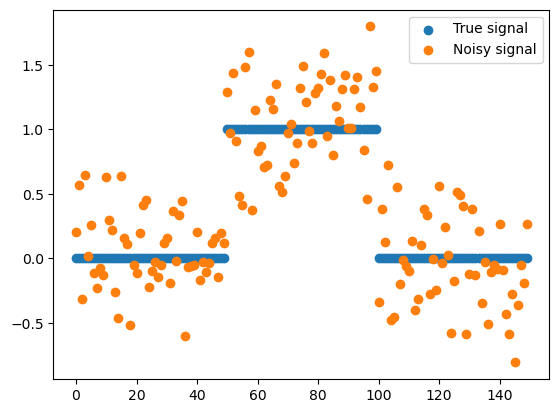

In [23]:
n=50
### vrai signal (normalement inconnu)
signal = np.concatenate((np.zeros(n), np.ones(n), np.zeros(n)))
### signal bruité (le seul dont on dispose 
noisy_signal = signal + np.random.normal(0, 0.3, n*3)

plt.scatter(range(3*n), signal, label='True signal')
plt.scatter(range(3*n), noisy_signal, label='Noisy signal')
plt.legend()
plt.show()

In [24]:
lam, u, mat_a, mat_b = d1_fused_lasso(noisy_signal)
beta = get_beta(u, noisy_signal)

**Exemple d'estimation pour un des lamba**

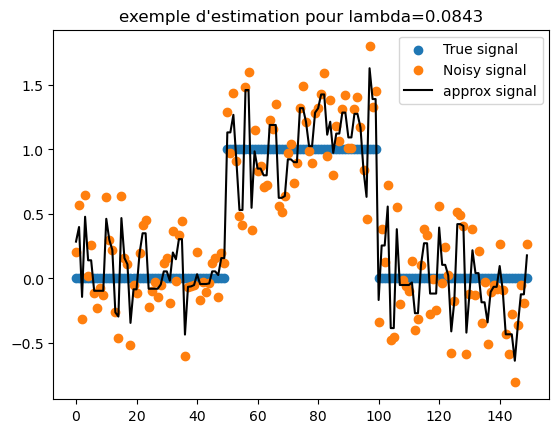

In [25]:
plt.scatter(range(3*n), signal, label='True signal')
plt.scatter(range(3*n), noisy_signal, label='Noisy signal')
plt.plot(range(3*n), beta[100], color='k', label='approx signal')
plt.title(f"exemple d'estimation pour lambda={lam[100]:.4f}")
plt.legend()

### **Calculons le lambda optimal**
$$
\lambda>0 \mapsto \frac{1}{2}\|Y-\hat{\beta}(\lambda)\|^2_2
$$

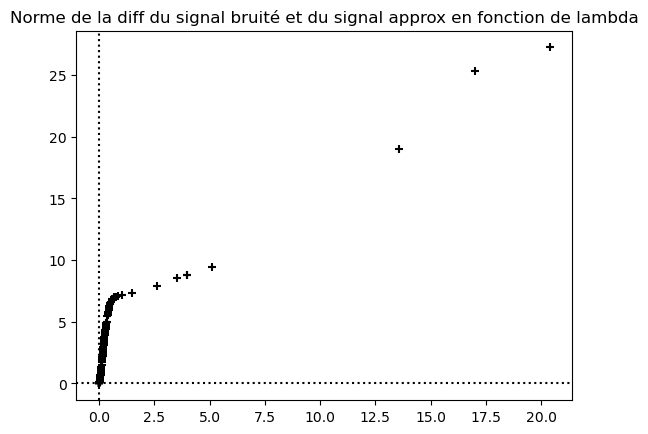

In [26]:
for i in range(len(lam[1:])):
    plt.scatter(lam[i+1], 0.5*np.linalg.norm(noisy_signal-beta[i+1])**2, color='k', marker='+')
plt.title('Norme de la diff du signal bruité et du signal approx en fonction de lambda')
norm_values = [0.5*np.linalg.norm(noisy_signal-beta[i+1])**2 for i in range(len(lam[1:]))]
lam_opt = lam[np.argmin(norm_values)]
index_opt = np.argmin(norm_values)
plt.axvline(x=lam_opt, linestyle=':', color='k')
plt.axhline(y=0.5*np.linalg.norm(noisy_signal-beta[index_opt+1])**2, linestyle=':', color='k')
#plt.axhline(y=0.5*np.linalg.norm(beta[-1]-signal)**2, linestyle=':', color='k')

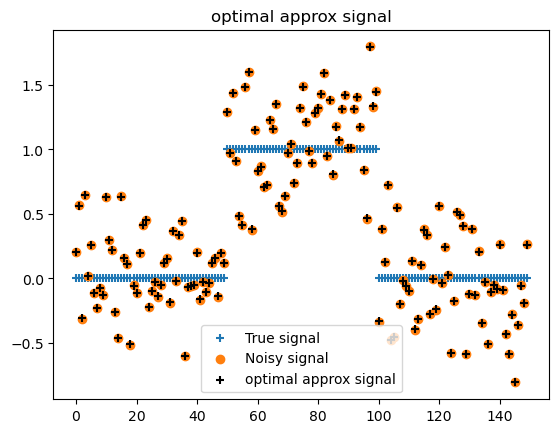

In [27]:
plt.scatter(range(3*n), signal, label='True signal', marker='+')
plt.scatter(range(3*n), noisy_signal, label='Noisy signal')
plt.scatter(range(3*n), beta[index_opt], color='k',marker='+', label='optimal approx signal')
plt.title('optimal approx signal')
plt.legend()

On peut donc se rendre compte que cette manière de choisir le paramètre $\lambda$ est un peu naïve car lorsqu'on minimise
$$
\lambda>0 \mapsto \frac{1}{2}\|Y-\hat{\beta}(\lambda)\|^2_2 ~~~ \text{(où Y est le signal bruité),}
$$
le $\lambda$ choisi est $\lambda_{opt}=0$ car $\hat{\beta}(0)=Y$ (estimateur des moindres carrés avec $X=I$) \
Et donc on a $\hat{\beta}(\lambda_{opt})=Y$ \
Une autre approche plus pertinente est de minimiser l'erreur quadratique moyenne 
$$
EQM(\hat{\beta}(\lambda)): \lambda>0 \mapsto \mathbb{E}\left[\|\hat{\beta}(\lambda)-\beta^*\|^2_2 \right]
$$ \
Ici, on dispose du vrai signal $\beta^*$. Mais en pratique on ne dispose pas de ce $\beta^*$, on utilise plutôt la formule SURE qui est un estimateur non biaisé de l'erreur quadratique moyenne.

50.88048005104065 s


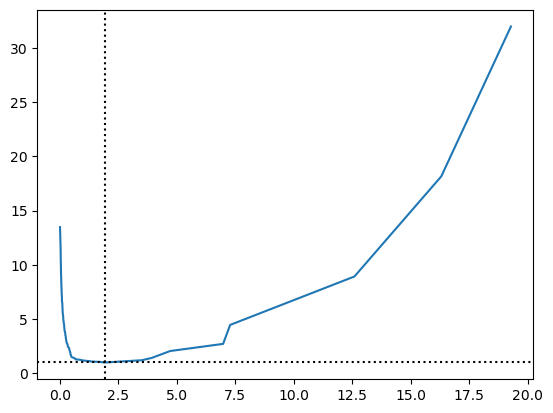

In [28]:
start_time = time.time()
k = 75
EQM_values = np.zeros(len(lam))
for i in range(k): 
    noisy_signal = signal + np.random.normal(0, 0.3, n*3)
    lam, u, mat_a, mat_b = d1_fused_lasso(noisy_signal)
    beta = get_beta(u, noisy_signal)
    beta = beta[1:]
    for j in range(len(lam)-1):
        val = np.linalg.norm(beta[j]-signal)**2
        EQM_values[j] = EQM_values[j] + val
EQM_values = EQM_values/k
plt.plot(lam[:-1], EQM_values[:-1])
mini = np.min(EQM_values[:-1])
ind_lam = np.argmin(EQM_values[:-1])
plt.axvline(x=lam[ind_lam], linestyle=':', color='k')
plt.axhline(y=mini, linestyle=':', color='k')
end_time = time.time()
print(end_time-start_time, "s")

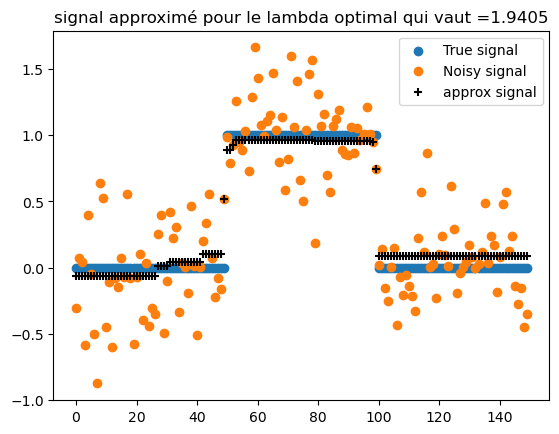

In [30]:
plt.scatter(range(3*n), signal, label='True signal')
plt.scatter(range(3*n), noisy_signal, label='Noisy signal')
plt.scatter(range(3*n), beta[ind_lam], color='k',marker='+', label='approx signal')
plt.title(f"signal approximé pour le lambda optimal qui vaut ={lam[ind_lam]:.4f}")
plt.legend()